# 성능 최적화


1.   배치 정규화
2.   드롭아웃
3.   조기 종료



In [1]:
# 라이브러리 호출 및 데이터셋 내려받기
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

In [2]:
# 데이터프레임에 데이터셋 저장
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df = df.astype(float)
df['label'] = iris.target
df['label'] = df.label.replace(dict(enumerate(iris.target_names)))

In [3]:
# 원-핫 인코딩 적용
label = pd.get_dummies(df['label'], prefix='label')
df = pd.concat([df, label], axis=1)
df.drop(['label'], axis=1, inplace=True)

In [4]:
# 데이터 셋 분류
x = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
x = np.asarray(x)
y = df[['label_setosa', 'label_versicolor', 'label_virginica']]
y = np.asarray(y)

In [5]:
# 데이터 셋 (훈련,테스트) 분리
x_train, x_test, y_train, y_test = train_test_split(
  x,
  y,
  test_size=0.20)

# 배치 정규화
>   기울기 소멸이나 기울기 폭발 같은 문제를 해결하기 위한 방법이다. <br/>

기울기 소멸과 폭발 원인은 내부 공변량 변화 때문인데, 이것은 네트워크의 각 층마다 활성화 함수가 적용되면서 입력 값들의 분포가 계속 바뀌는 현상을 의미한다.
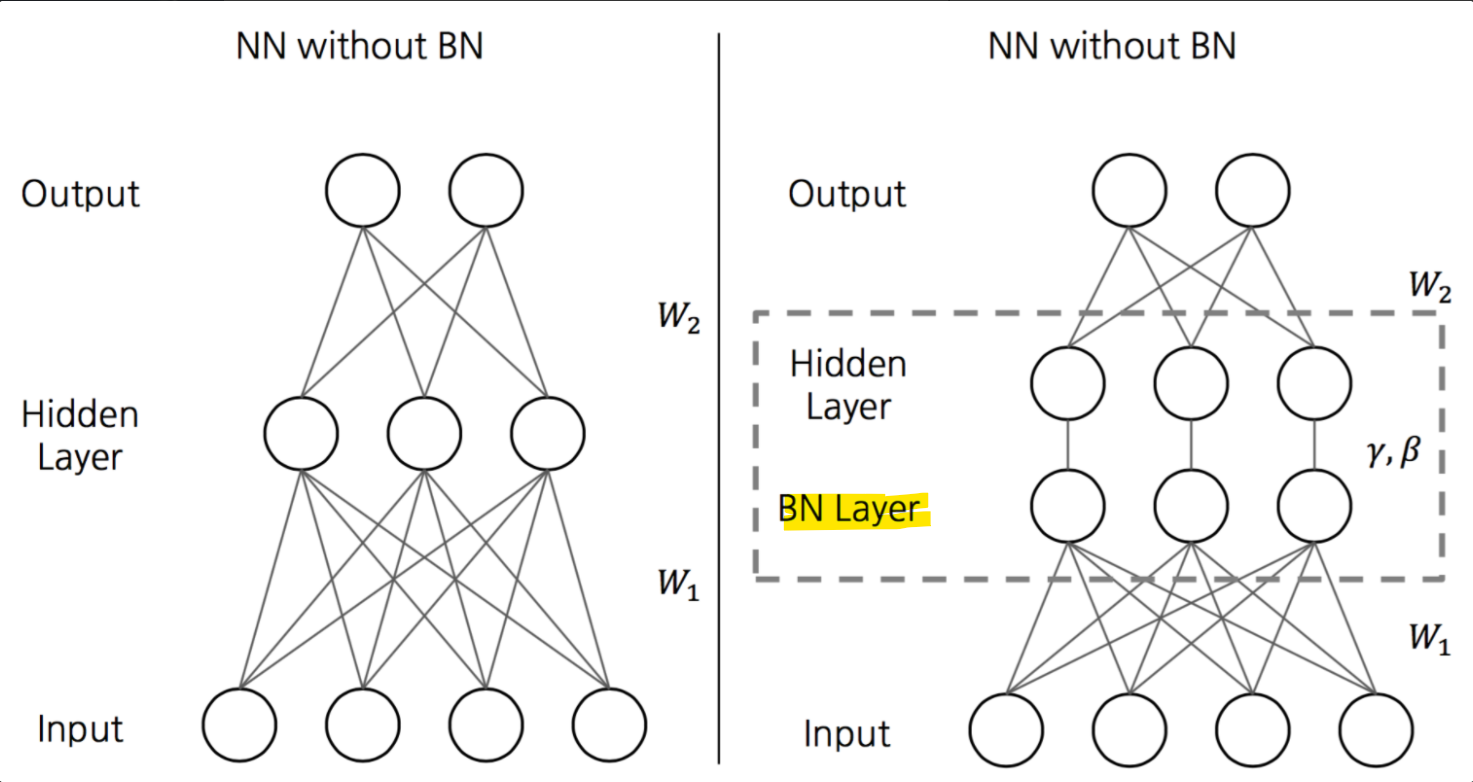
<br/> 
따라서 **분산된 분포를 정규 분포로 만들기 위해 표준화와 유사한 방식을 미니 배치에 적용하여 평균을 0으로, 표준편차는 1로 유지하도록 한다.** ( = 배치 정규화)


<br/>

*   기울기 소멸 : 오차 정보를 역전파 시키는 과정에서 기울기가 급격히 0에 가까워져 학습이 되지 않는 현상이다.
*   기울기 폭발 : 학습 과정에서 기울기가 급격히 커지는 현상이다.

## 배치 정규화를 적용하지 않은 모델

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

# 배치 정규화를 적용하지 않은 모델 생성
model1 = Sequential([
    Dense(64, input_shape=(4,), activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
]);

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 37,763
Trainable params: 37,763
Non-traina

In [7]:
# 모델 훈련
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.25,
    batch_size=40,
    verbose=2
)

Epoch 1/100
3/3 - 3s - loss: 1.0800 - accuracy: 0.5000 - val_loss: 0.8748 - val_accuracy: 0.7333 - 3s/epoch - 837ms/step
Epoch 2/100
3/3 - 0s - loss: 0.9203 - accuracy: 0.6889 - val_loss: 0.8293 - val_accuracy: 0.9000 - 58ms/epoch - 19ms/step
Epoch 3/100
3/3 - 0s - loss: 0.8040 - accuracy: 0.8222 - val_loss: 0.6927 - val_accuracy: 0.7333 - 71ms/epoch - 24ms/step
Epoch 4/100
3/3 - 0s - loss: 0.6994 - accuracy: 0.6889 - val_loss: 0.6048 - val_accuracy: 0.7333 - 49ms/epoch - 16ms/step
Epoch 5/100
3/3 - 0s - loss: 0.5976 - accuracy: 0.7111 - val_loss: 0.5521 - val_accuracy: 0.9000 - 39ms/epoch - 13ms/step
Epoch 6/100
3/3 - 0s - loss: 0.5153 - accuracy: 0.8556 - val_loss: 0.4685 - val_accuracy: 0.9000 - 86ms/epoch - 29ms/step
Epoch 7/100
3/3 - 0s - loss: 0.4332 - accuracy: 0.8667 - val_loss: 0.4116 - val_accuracy: 0.9000 - 89ms/epoch - 30ms/step
Epoch 8/100
3/3 - 0s - loss: 0.3813 - accuracy: 0.9667 - val_loss: 0.3658 - val_accuracy: 0.9333 - 48ms/epoch - 16ms/step
Epoch 9/100
3/3 - 0s - lo

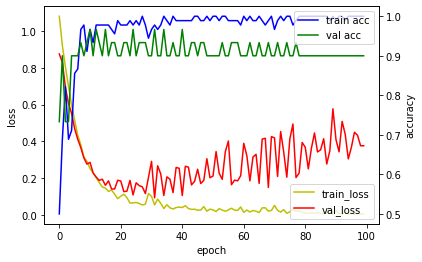

In [8]:
# 훈련 결과 시각화
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history1.history['loss'], 'y', label='train_loss')
loss_ax.plot(history1.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history1.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history1.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='lower right')
acc_ax.legend(loc='upper right')
plt.show()

In [9]:
# 정확도와 손실 정보 표현
loss_and_metrics = model1.evaluate(x_test, y_test)
print("## 손실과 정확도 평가 ##")
print(loss_and_metrics)

1/1 [==============================] - 0s 19ms/step - loss: 0.0906 - accuracy: 0.9333
## 손실과 정확도 평가 ##
[0.09056523442268372, 0.9333333373069763]


## 배치 정규화가 적용된 모델

In [10]:
# 배치 정규화가 적용된 모델
from tensorflow.keras.initializers import RandomNormal, Constant
model2 = Sequential([
    Dense(64, input_shape=(4,), activation='relu'),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(
        momentum=0.95,
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
        gamma_initializer=Constant(value=0.9)
    ),
    Dense(3, activation='softmax')
]);
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                320       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_2 (Batc  (None, 128)             

In [11]:
# 모델 훈련
model2.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history2 = model2.fit(
    x_train, 
    y_train, 
    epochs=1000, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2
)

Epoch 1/1000
3/3 - 1s - loss: 1.4044 - accuracy: 0.4222 - val_loss: 1.0721 - val_accuracy: 0.4667 - 1s/epoch - 468ms/step
Epoch 2/1000
3/3 - 0s - loss: 0.4342 - accuracy: 0.8889 - val_loss: 1.0492 - val_accuracy: 0.4667 - 39ms/epoch - 13ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.2235 - accuracy: 0.9667 - val_loss: 1.0293 - val_accuracy: 0.5333 - 35ms/epoch - 12ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.1525 - accuracy: 0.9667 - val_loss: 1.0136 - val_accuracy: 0.4667 - 33ms/epoch - 11ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.1221 - accuracy: 0.9667 - val_loss: 1.0024 - val_accuracy: 0.5333 - 35ms/epoch - 12ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.0811 - accuracy: 0.9889 - val_loss: 0.9963 - val_accuracy: 0.5333 - 34ms/epoch - 11ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.0778 - accuracy: 0.9778 - val_loss: 0.9799 - val_accuracy: 0.6000 - 39ms/epoch - 13ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.0608 - accuracy: 1.0000 - val_loss: 0.9631 - val_accuracy: 0.5667 - 37ms/epoch - 12ms/step
Epoch 9/1000
3/3 

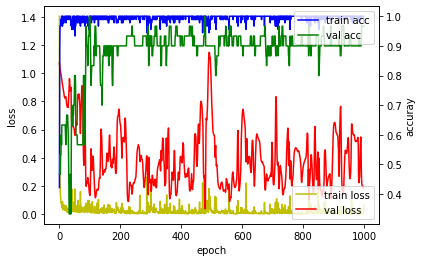

In [12]:
# 훈련 결과 시각화
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history2.history['loss'], 'y', label='train loss')
loss_ax.plot(history2.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history2.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history2.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='lower right')
acc_ax.legend(loc='upper right')
plt.show()

In [13]:
# 모델 평가
loss_and_metrics = model2.evaluate(x_test, y_test)
print('## 손실과 정확도 평가  ##')
print(loss_and_metrics)

1/1 [==============================] - 0s 21ms/step - loss: 0.1326 - accuracy: 0.9667
## 손실과 정확도 평가  ##
[0.1325693279504776, 0.9666666388511658]


## 드롭아웃을 이용한 성능 최적화

>   훈련할 때 일정 비율의 뉴런만 사용하고, 나머지 뉴런에 해당하는 가중치는 업데이트 하지 않는 방법입니다. (매 단계마다 사용하지 않는 뉴런을 바꾸어 가며 훈련을 시킵니다.)
>   드롭아웃은 노드를 임의로 끄면서 학습하는 방법으로, 은닉층에 배치된 노드 중 일부를 임의로 끄면서 학습합니다.

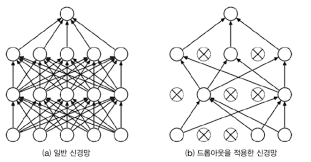

In [ ]:
# 라이브러리 호출
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
# 데이터셋 내려받기
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    with_info = True, as_supervised=True)

padded_shapes = ([None], ())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3449J9/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3449J9/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3449J9/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[2518,  148,   63, ...,    0,    0,    0],
       [  62,    9,    4, ...,    0,    0,    0],
       [ 519,   92,   11, ...,    0,    0,    0],
       ...,
       [  62,  577,  897, ...,    0,    0,    0],
       [  19,  188,    9, ...,    0,    0,    0],
       [3655,   40,    1, ...,    0,    0,    0]])

In [ ]:
train_labels.numpy()

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1])

## 드롭아웃이 적용되지 않은 모델

In [ ]:
# 드롭아웃이 적용되지 않은 모델
encoder = info.features['text'].encoder
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# 모델 훈련
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
history = model.fit(train_batches, epochs=5, validation_data=test_batches, validation_steps=30)

Epoch 1/5
2500/2500 [==============================] - 85s 32ms/step - loss: 0.6930 - accuracy: 0.5045 - val_loss: 0.6912 - val_accuracy: 0.5167
Epoch 2/5
2500/2500 [==============================] - 78s 31ms/step - loss: 0.6866 - accuracy: 0.5126 - val_loss: 0.6895 - val_accuracy: 0.5233
Epoch 3/5
2500/2500 [==============================] - 78s 31ms/step - loss: 0.6673 - accuracy: 0.5401 - val_loss: 0.6621 - val_accuracy: 0.5400
Epoch 4/5
2500/2500 [==============================] - 78s 31ms/step - loss: 0.6536 - accuracy: 0.5569 - val_loss: 0.7000 - val_accuracy: 0.5100
Epoch 5/5
2500/2500 [==============================] - 79s 32ms/step - loss: 0.5734 - accuracy: 0.7059 - val_loss: 0.6343 - val_accuracy: 0.6200


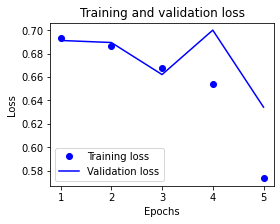

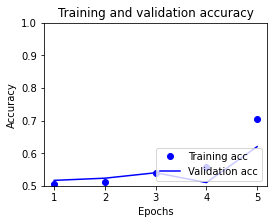

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_batches.shuffle(BUFFER_SIZE)

import matplotlib.pyplot as plt
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(4,3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## 드롭아웃이 적용된 모델

In [ ]:
# 드롭아웃이 적용된 모델
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                

In [ ]:
model.compile(loss='binary_crossentropy',          
              optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
history = model.fit(train_batches, epochs=5, validation_data=test_batches, validation_steps=30)

Epoch 1/5
2500/2500 [==============================] - 259s 101ms/step - loss: 0.5774 - accuracy: 0.6752 - val_loss: 0.4449 - val_accuracy: 0.8200
Epoch 2/5
2500/2500 [==============================] - 239s 95ms/step - loss: 0.3190 - accuracy: 0.8782 - val_loss: 0.3278 - val_accuracy: 0.8700
Epoch 3/5
2500/2500 [==============================] - 240s 96ms/step - loss: 0.2507 - accuracy: 0.9102 - val_loss: 0.4191 - val_accuracy: 0.8500
Epoch 4/5
2500/2500 [==============================] - 240s 96ms/step - loss: 0.2117 - accuracy: 0.9270 - val_loss: 0.3164 - val_accuracy: 0.8933
Epoch 5/5
2500/2500 [==============================] - 238s 95ms/step - loss: 0.1802 - accuracy: 0.9418 - val_loss: 0.4159 - val_accuracy: 0.8767


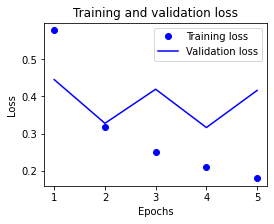

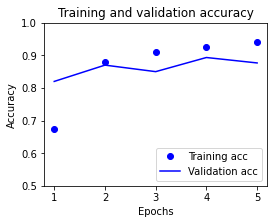

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_batches.shuffle(BUFFER_SIZE)
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(4,3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [ ]:
#드롭아웃은 제거하고, 양방향(Bidirectional) RNN만 적용했을 때
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',          
              optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
history = model.fit(train_batches, epochs=5, validation_data=test_batches, validation_steps=30)

Epoch 1/5
2500/2500 [==============================] - 152s 59ms/step - loss: 0.5068 - accuracy: 0.7304 - val_loss: 0.3634 - val_accuracy: 0.8467
Epoch 2/5
2500/2500 [==============================] - 144s 58ms/step - loss: 0.2865 - accuracy: 0.8901 - val_loss: 0.4047 - val_accuracy: 0.8433
Epoch 3/5
2500/2500 [==============================] - 146s 58ms/step - loss: 0.2596 - accuracy: 0.9017 - val_loss: 0.4089 - val_accuracy: 0.8533
Epoch 4/5
2500/2500 [==============================] - 144s 57ms/step - loss: 0.1972 - accuracy: 0.9302 - val_loss: 0.4297 - val_accuracy: 0.8467
Epoch 5/5
2500/2500 [==============================] - 145s 58ms/step - loss: 0.1722 - accuracy: 0.9404 - val_loss: 0.4185 - val_accuracy: 0.8633


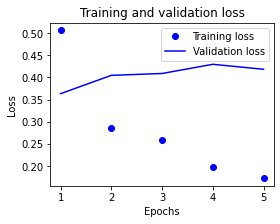

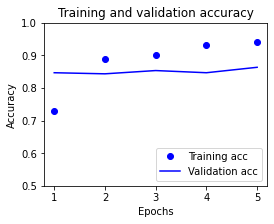

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_batches.shuffle(BUFFER_SIZE)
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(4,3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## 조기종료
*   뉴럴 네트워크가 **과적합을 회피**하는 규제 기법이다.
*   매 에포크마다 테스트 데이터에 대한 **오차를 측정**하여 **모델의 종료 시점**을 제어한다.
*   종료 시점을 확인하기 위한 **콜백 함수**를 반드시 같이 사용해야 한다.

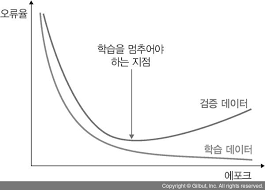

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb
import tensorflow as tf
import numpy as np

In [ ]:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 300
np.random.seed(7)

In [ ]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)

>   tf.keras.callbacks.ModelCheckpoint 콜백함수는 훈련하는 동안 체크포인트를 저장하여, 다시 훈련하지 않고 모델을 재사용하거나 의도치 않게 훈련이 중지된 경우 이어서 훈련할 수 있도록 도와주는 함수이다.

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 모양(길이)이 같은 벡터를 만들기 위해 '0'을 시퀀스로 채워준다.
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 50)           250000    
                                                                 
 dropout (Dropout)           (None, 400, 50)           0         
                                                                 
 conv1d (Conv1D)             (None, 398, 250)          37750     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                        

### Embedding(max_features,embedding_dims,input_length=maxlen))


*   max_features : 단어 사전의 크기를 의미한다. (imdb.load_data() 메서드의 num_words의 값과 동일해야 한다.
*   embedding_dims : 단어를 인코딩한 후 나오는 벡터 크기이다. (50인 경우 단어가 50차원의 기하 공간에 표현되었다는 의미이다.)
*   input_length : 단어 수 = 문장의 길이를 나타낸다.

----

### Conv1D
*   문장 해석을 위해 Conv1D를 사용한다.
*   합성곱층은 위치를 무시하고 지역적인 특성을 잘 뽑아낸다. 
*   합성곱을 문장에 적용한다면 주요 단어가 문장 앞뒤에 있더라도 전후 문맥을 고려하여 특성을 뽑아낼 수 있다.

---

### GlobalMaxPooling
*   합성곱층이 문장을 훑어 가면서 뽑아낸 특성 벡터 중 가장 큰 벡터를 선택한다.



### 조기 종료가 추가되지 않은 모델 훈련

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[cp_callback])

Epoch 1/300
617/625 [============================>.] - ETA: 0s - loss: 0.4341 - accuracy: 0.7801
Epoch 1: saving model to training_1/cp.ckpt
INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets
625/625 [==============================] - 23s 11ms/step - loss: 0.4329 - accuracy: 0.7808 - val_loss: 0.3034 - val_accuracy: 0.8700
Epoch 2/300
621/625 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9010
Epoch 2: saving model to training_1/cp.ckpt
INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets
625/625 [==============================] - 6s 10ms/step - loss: 0.2452 - accuracy: 0.9009 - val_loss: 0.2612 - val_accuracy: 0.8922
Epoch 3/300
618/625 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9383
Epoch 3: saving model to training_1/cp.ckpt
INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets
625/625 [==============================] - 6s 10ms/step - loss: 0.1659 - accuracy: 0.9380 - val_loss: 0.2801 - val_accuracy: 0.89

In [8]:
# 모델 평가
from tensorflow.keras.models import load_model
model = load_model(checkpoint_path)
scores = model.evaluate(x_test, y_test, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

782/782 [==============================] - 3s 3ms/step - loss: 1.5426 - accuracy: 0.8736
Score: loss of 1.5425995588302612; accuracy of 87.36400008201599%


### 조기 종료를 적용한 모델

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
keras_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=keras_callbacks)

Epoch 1/300
625/625 [==============================] - 6s 8ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 2.6699 - val_accuracy: 0.8824
Epoch 2/300
625/625 [==============================] - 5s 8ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 2.2022 - val_accuracy: 0.8888
Epoch 3/300
625/625 [==============================] - 5s 8ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 1.5900 - val_accuracy: 0.8864
Epoch 4/300
625/625 [==============================] - 4s 6ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 2.0326 - val_accuracy: 0.8848
Epoch 5/300
625/625 [==============================] - 4s 7ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 2.1273 - val_accuracy: 0.8818
Epoch 6/300
625/625 [==============================] - 4s 7ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 2.0130 - val_accuracy: 0.8876
Epoch 7/300
625/625 [==============================] - 4s 6ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 1.8264 - val_accuracy: 0.8910

### EarlyStopping
*   monitor : 관찰하고자 하는 항목 (val_loss, val_acc 주로 사용함)
*   patience : 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄지를 지정한다.
*   mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정한다. (min같은 경우 'val_loss'가 더이상 감소가 되지 않을 때 종료하기 위해 사용한다.)
*   min_delta : 개선되고 있다 판단하기 위한 최소 변화량을 나타낸다.

In [10]:
# 모델 평가
model = load_model(checkpoint_path)
scores = model.evaluate(x_test, y_test, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

782/782 [==============================] - 3s 3ms/step - loss: 1.4052 - accuracy: 0.8745
Score: loss of 1.4051636457443237; accuracy of 87.45200037956238%
